# Multimodal Report Generation Agent 

<a href="https://colab.research.google.com/github/run-llama/llama_parse/blob/main/examples/multimodal/multimodal_report_generation_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this cookbook we show you how to build a multimodal report generation agent from a bank of research reports. We use the a set of ICLR papers (which were also used as the dataset in our [DeepLearning.ai course](https://www.deeplearning.ai/short-courses/building-agentic-rag-with-llamaindex/?utm_campaign=llamaindexC2-launch&utm_medium=headband&utm_source=dlai-homepage).

We use our workflow abstraction to define an agentic system that contains two main phases: a research phase that pulls in relevant files through chunk-level or file-level retrieval, and then a blog generation phase that synthesizes the final report.

## Setup

In [ ]:
import nest_asyncio

nest_asyncio.apply()

### Setup Observability

We setup an integration with LlamaTrace (integration with Arize).

If you haven't already done so, make sure to create an account here: https://llamatrace.com/login. Then create an API key and put it in the `PHOENIX_API_KEY` variable below.

In [ ]:
!pip install -U llama-index-callbacks-arize-phoenix

In [ ]:
# setup Arize Phoenix for logging/observability
import llama_index.core
import os

PHOENIX_API_KEY = "<PHOENIX_API_KEY>"
os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"
llama_index.core.set_global_handler(
    "arize_phoenix", endpoint="https://llamatrace.com/v1/traces"
)

### Model Setup

Setup models that will be used for downstream orchestration.

In [ ]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(model="text-embedding-3-large")
llm = OpenAI(model="gpt-4o")

Settings.embed_model = embed_model
Settings.llm = llm

## Load, Parse, and Index Research Papers

Here we load 11 popular ICLR 2024 papers, and then we parse through LlamaParse.

In [ ]:
urls = [
    "https://openreview.net/pdf?id=VtmBAGCN7o",
    "https://openreview.net/pdf?id=6PmJoRfdaK",
    "https://openreview.net/pdf?id=LzPWWPAdY4",
    "https://openreview.net/pdf?id=VTF8yNQM66",
    "https://openreview.net/pdf?id=hSyW5go0v8",
    "https://openreview.net/pdf?id=9WD9KwssyT",
    "https://openreview.net/pdf?id=yV6fD7LYkF",
    "https://openreview.net/pdf?id=hnrB5YHoYu",
    "https://openreview.net/pdf?id=WbWtOYIzIK",
    "https://openreview.net/pdf?id=c5pwL0Soay",
    "https://openreview.net/pdf?id=TpD2aG1h0D",
]

# NOTE: uncomment more papers if you want to do research over a larger subset of docs
papers = [
    "metagpt.pdf",
    "longlora.pdf",
    "loftq.pdf",
    # "swebench.pdf",
    # "selfrag.pdf",
    # "zipformer.pdf",
    # "values.pdf",
    # "finetune_fair_diffusion.pdf",
    # "knowledge_card.pdf",
    # "metra.pdf",
    # "vr_mcl.pdf",
]

data_dir = "iclr_docs"

In [ ]:
!mkdir "{data_dir}"
for url, paper in zip(urls, papers):
    !wget "{url}" -O "{data_dir}/{paper}"

In [ ]:
from llama_parse import LlamaParse

parser = LlamaParse(
    result_type="markdown",
    use_vendor_multimodal_model=True,
    vendor_multimodal_model_name="anthropic-sonnet-3.5",
)

**NOTE**: this may be slow. To save your results, run the cell to save all your outputs to JSON, so you can reload instead of having to re-parse.

*If you've already saved the text nodes*, skip ahead to the cell with the "LOAD" comment.

In [ ]:
from pathlib import Path

# delete and recreate the image directory if not already created
out_image_dir = "out_iclr_images"
!rm -rf "{out_image_dir}"
!mkdir "{out_image_dir}"


paper_dicts = {}

for paper_path in papers:
    paper_base = Path(paper_path).stem
    full_paper_path = str(Path(data_dir) / paper_path)
    md_json_objs = parser.get_json_result(full_paper_path)
    json_dicts = md_json_objs[0]["pages"]

    image_path = str(Path(out_image_dir) / paper_base)
    image_dicts = parser.get_images(md_json_objs, download_path=image_path)
    paper_dicts[paper_path] = {
        "paper_path": full_paper_path,
        "json_dicts": json_dicts,
        "image_path": image_path,
    }

#### Get Text Nodes

Convert the dictionary above into TextNode objects that we can put into a vector store.

In [ ]:
from llama_index.core.schema import TextNode
from typing import Optional

In [ ]:
# NOTE: these are utility functions to sort the dumped images by the page number
# (they are formatted like "{uuid}-{page_num}.jpg"
import re


def get_page_number(file_name):
    match = re.search(r"-page-(\d+)\.jpg$", str(file_name))
    if match:
        return int(match.group(1))
    return 0


def _get_sorted_image_files(image_dir):
    """Get image files sorted by page."""
    raw_files = [f for f in list(Path(image_dir).iterdir()) if f.is_file()]
    sorted_files = sorted(raw_files, key=get_page_number)
    return sorted_files

In [ ]:
from copy import deepcopy
from pathlib import Path


# attach image metadata to the text nodes
def get_text_nodes(json_dicts, paper_path, image_dir=None):
    """Split docs into nodes, by separator."""
    nodes = []

    image_files = _get_sorted_image_files(image_dir) if image_dir is not None else None
    md_texts = [d["md"] for d in json_dicts]

    for idx, md_text in enumerate(md_texts):
        chunk_metadata = {
            "page_num": idx + 1,
            "parsed_text_markdown": md_text,
            "paper_path": paper_path,
        }
        if image_files is not None:
            image_file = image_files[idx]
            chunk_metadata["image_path"] = str(image_file)
        chunk_metadata["parsed_text_markdown"] = md_text
        node = TextNode(
            text="",
            metadata=chunk_metadata,
        )
        nodes.append(node)

    return nodes

In [ ]:
# this will combine all nodes from all papers into a single list
all_text_nodes = []
text_nodes_dict = {}
for paper_path, paper_dict in paper_dicts.items():
    json_dicts = paper_dict["json_dicts"]
    text_nodes = get_text_nodes(
        json_dicts, paper_dict["paper_path"], image_dir=paper_dict["image_path"]
    )
    all_text_nodes.extend(text_nodes)
    text_nodes_dict[paper_path] = text_nodes

You can choose to save these nodes if you'd like.

In [ ]:
# SAVE
import pickle

pickle.dump(text_nodes_dict, open("iclr_text_nodes.pkl", "wb"))

**LOAD**: If you've already saved nodes, run the below cell to load from an existing file.

In [ ]:
# LOAD
import pickle

text_nodes_dict = pickle.load(open("iclr_text_nodes.pkl", "rb"))

In [ ]:
all_text_nodes = []
for paper_path, text_nodes in text_nodes_dict.items():
    all_text_nodes.extend(text_nodes)

In [ ]:
print(all_text_nodes[10].get_content(metadata_mode="all"))

page_num: 11
parsed_text_markdown: Preprint

Weize Chen, Yusheng Su, Jingwei Zuo, Cheng Yang, Chenfei Yuan, Chen Qian, Chi-Min Chan, Yujia Qin, Yaxi Lu, Ruobing Xie, Zhiyuan Liu, Maosong Sun, and Jie Zhou. Agentverse: Facilitating multi-agent collaboration and exploring emergent behaviors in agents, 2023.

Xinyun Chen, Chang Liu, and Dawn Song. Execution-guided neural program synthesis. In ICLR, 2018.

Xinyun Chen, Dawn Song, and Yuandong Tian. Latent execution for neural program synthesis beyond domain-specific languages. NeurIPS, 2021b.

Aakanksha Chowdhery, Sharan Narang, Jacob Devlin, Maarten Bosma, Gaurav Mishra, Adam Roberts, Paul Barham, Hyung Won Chung, Charles Sutton, Sebastian Gehrmann, Parker Schuh, Kensen Shi, Sasha Tsvyashchenko, Joshua Maynez, Abhishek Rao, Parker Barnes, Yi Tay, Noam Shazeer, Vinodkumar Prabhakaran, Emily Reif, Nan Du, Ben Hutchinson, Reiner Pope, James Bradbury, Jacob Austin, Michael Isard, Guy Gur-Ari, Pengcheng Yin, Toju Duke, Anselm Levskaya, Sanjay 

### Build Indexes

Once the text nodes are ready, we feed into our vector store index abstraction, which will index these nodes into a simple in-memory vector store (of course, you should definitely check out our 40+ vector store integrations!)

Besides vector indexing, we **also** store a mapping of paper path to the summary index. This allows us to perform document-level retrieval - retrieve all chunks relevant to a given document.

In [ ]:
import os
from llama_index.core import (
    StorageContext,
    SummaryIndex,
    VectorStoreIndex,
    load_index_from_storage,
)

# Vector Indexing
if not os.path.exists("storage_nodes_papers"):
    index = VectorStoreIndex(all_text_nodes)
    # save index to disk
    index.set_index_id("vector_index")
    index.storage_context.persist("./storage_nodes_papers")
else:
    # rebuild storage context
    storage_context = StorageContext.from_defaults(persist_dir="storage_nodes_papers")
    # load index
    index = load_index_from_storage(storage_context, index_id="vector_index")


# Summary Index dictionary - store map from paper path to a summary index around it
paper_summary_indexes = {
    paper_path: SummaryIndex(text_nodes_dict[paper_path]) for paper_path in papers
}

## Define Tools

We define two tools for the downstream agent: a chunk-level retriever tool and a document-retrieval tool.

In [ ]:
from llama_index.core.tools import FunctionTool
from llama_index.core.schema import NodeWithScore
from typing import List


# function tools
def chunk_retriever_fn(query: str) -> List[NodeWithScore]:
    """Retrieves a small set of relevant document chunks from the corpus.

    ONLY use for research questions that want to look up specific facts from the knowledge corpus,
    and don't need entire documents.

    """
    retriever = index.as_retriever(similarity_top_k=5)
    nodes = retriever.retrieve(query)
    return nodes


def _get_document_nodes(
    nodes: List[NodeWithScore], top_n: int = 2
) -> List[NodeWithScore]:
    """Get document nodes from a set of chunk nodes.

    Given chunk nodes, "de-reference" into a set of documents, with a simple weighting function (cumulative total) to determine ordering.

    Cutoff by top_n.

    """
    paper_paths = {n.metadata["paper_path"] for n in nodes}
    paper_path_scores = {f: 0 for f in paper_paths}
    for n in nodes:
        paper_path_scores[n.metadata["paper_path"]] += n.score

    # Sort paper_path_scores by score in descending order
    sorted_paper_paths = sorted(
        paper_path_scores.items(), key=itemgetter(1), reverse=True
    )
    # Take top_n paper paths
    top_paper_paths = [path for path, score in sorted_paper_paths[:top_n]]

    # use summary index to get nodes from all paper paths
    all_nodes = []
    for paper_path in top_paper_paths:
        # NOTE: input to retriever can be blank
        all_nodes.extend(
            paper_summary_indexes[Path(paper_path).name].as_retriever().retrieve("")
        )

    return all_nodes


def doc_retriever_fn(query: str) -> float:
    """Document retriever that retrieves entire documents from the corpus.

    ONLY use for research questions that may require searching over entire research reports.

    Will be slower and more expensive than chunk-level retrieval but may be necessary.
    """
    retriever = index.as_retriever(similarity_top_k=5)
    nodes = retriever.retrieve(query)
    return _get_document_nodes(nodes)


chunk_retriever_tool = FunctionTool.from_defaults(fn=chunk_retriever_fn)
doc_retriever_tool = FunctionTool.from_defaults(fn=doc_retriever_fn)

## Build Workflow 

Now that we've built the index, we're ready to build the report generation workflow. 

The workflow contains roughly the following steps: 

1. **Research Gathering**: Perform a function calling loop where the agent tries to reason about what tool to call (chunk-level or document-level retrieval) in order to gather more information. All information is shared to a dictionary that is propagated throughout each step. The tools return an indication of the type of information returned to the agent. After the agent feels like it's gathered enough information, move on to the next phase.


2. **Report Generation**: Generate a research report given the pooled research. For now, try to stuff as much information into the context window through the summary index.


This implementation is inspired by our [Function Calling Agent workflow](https://docs.llamaindex.ai/en/latest/examples/workflow/function_calling_agent/) implementation.

In [ ]:
from llama_index.llms.openai import OpenAI
from pydantic.v1 import BaseModel, Field
from typing import List
from IPython.display import display, Markdown, Image


class TextBlock(BaseModel):
    """Text block."""

    text: str = Field(..., description="The text for this block.")


class ImageBlock(BaseModel):
    """Image block."""

    file_path: str = Field(..., description="File path to the image.")


class ReportOutput(BaseModel):
    """Data model for a report.

    Can contain a mix of text and image blocks. MUST contain at least one image block.

    """

    blocks: List[TextBlock | ImageBlock] = Field(
        ..., description="A list of text and image blocks."
    )

    def render(self) -> None:
        """Render as HTML on the page."""
        for b in self.blocks:
            if isinstance(b, TextBlock):
                display(Markdown(b.text))
            else:
                display(Image(filename=b.file_path))


report_gen_system_prompt = """\
You are a report generation assistant tasked with producing a well-formatted context given parsed context.

You will be given context from one or more reports that take the form of parsed text.

You are responsible for producing a report with interleaving text and images - in the format of interleaving text and "image" blocks.
Since you cannot directly produce an image, the image block takes in a file path - you should write in the file path of the image instead.

How do you know which image to generate? Each context chunk will contain metadata including an image render of the source chunk, given as a file path. 
Include ONLY the images from the chunks that have heavy visual elements (you can get a hint of this if the parsed text contains a lot of tables).
You MUST include at least one image block in the output.

You MUST output your response as a tool call in order to adhere to the required output format. Do NOT give back normal text.

"""
report_gen_llm = OpenAI(model="gpt-4o", system_prompt=report_gen_system_prompt)
report_gen_sllm = llm.as_structured_llm(output_cls=ReportOutput)

In [ ]:
from llama_index.core.workflow import Workflow

from typing import Any, List
from operator import itemgetter

from llama_index.core.llms.function_calling import FunctionCallingLLM
from llama_index.core.llms.structured_llm import StructuredLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.llms import ChatMessage
from llama_index.core.tools.types import BaseTool
from llama_index.core.tools import ToolSelection
from llama_index.core.workflow import Workflow, StartEvent, StopEvent, Context, step
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.response_synthesizers import CompactAndRefine
from llama_index.core.workflow import Event


class InputEvent(Event):
    input: List[ChatMessage]


class ChunkRetrievalEvent(Event):
    tool_call: ToolSelection


class DocRetrievalEvent(Event):
    tool_call: ToolSelection


class ReportGenerationEvent(Event):
    pass


class ReportGenerationAgent(Workflow):
    """Report generation agent."""

    def __init__(
        self,
        chunk_retriever_tool: BaseTool,
        doc_retriever_tool: BaseTool,
        llm: FunctionCallingLLM | None = None,
        report_gen_sllm: StructuredLLM | None = None,
        **kwargs: Any,
    ) -> None:
        super().__init__(**kwargs)
        self.chunk_retriever_tool = chunk_retriever_tool
        self.doc_retriever_tool = doc_retriever_tool

        self.llm = llm or OpenAI()
        self.summarizer = CompactAndRefine(llm=self.llm)
        assert self.llm.metadata.is_function_calling_model

        self.report_gen_sllm = report_gen_sllm or self.llm.as_structured_llm(
            ReportOutput, system_prompt=report_gen_system_prompt
        )
        self.report_gen_summarizer = CompactAndRefine(llm=self.report_gen_sllm)

        self.memory = ChatMemoryBuffer.from_defaults(llm=llm)
        self.sources = []

    @step(pass_context=True)
    async def prepare_chat_history(self, ctx: Context, ev: StartEvent) -> InputEvent:
        # clear sources
        self.sources = []

        ctx.data["stored_chunks"] = []
        ctx.data["query"] = ev.input

        # get user input
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        self.memory.put(user_msg)

        # get chat history
        chat_history = self.memory.get()
        return InputEvent(input=chat_history)

    @step(pass_context=True)
    async def handle_llm_input(
        self, ctx: Context, ev: InputEvent
    ) -> ChunkRetrievalEvent | DocRetrievalEvent | ReportGenerationEvent | StopEvent:
        chat_history = ev.input

        response = await self.llm.achat_with_tools(
            [self.chunk_retriever_tool, self.doc_retriever_tool],
            chat_history=chat_history,
        )
        self.memory.put(response.message)

        tool_calls = self.llm.get_tool_calls_from_response(
            response, error_on_no_tool_call=False
        )
        if not tool_calls:
            # all the content should be stored in the context, so just pass along input
            return ReportGenerationEvent(input=ev.input)

        for tool_call in tool_calls:
            if tool_call.tool_name == self.chunk_retriever_tool.metadata.name:
                return ChunkRetrievalEvent(tool_call=tool_call)
            elif tool_call.tool_name == self.doc_retriever_tool.metadata.name:
                return DocRetrievalEvent(tool_call=tool_call)
            else:
                return StopEvent(result={"response": "Invalid tool."})

    @step(pass_context=True)
    async def handle_retrieval(
        self, ctx: Context, ev: ChunkRetrievalEvent | DocRetrievalEvent
    ) -> InputEvent:
        """Handle retrieval.

        Store retrieved chunks, and go back to agent reasoning loop.

        """
        query = ev.tool_call.tool_kwargs["query"]
        if isinstance(ev, ChunkRetrievalEvent):
            retrieved_chunks = self.chunk_retriever_tool(query).raw_output
        else:
            retrieved_chunks = self.doc_retriever_tool(query).raw_output
        ctx.data["stored_chunks"].extend(retrieved_chunks)

        # synthesize an answer given the query to return to the LLM.
        response = self.summarizer.synthesize(query, nodes=retrieved_chunks)
        self.memory.put(
            ChatMessage(
                role="tool",
                content=str(response),
                additional_kwargs={
                    "tool_call_id": ev.tool_call.tool_id,
                    "name": ev.tool_call.tool_name,
                },
            )
        )

        # send input event back with updated chat history
        return InputEvent(input=self.memory.get())

    @step(pass_context=True)
    async def generate_report(
        self, ctx: Context, ev: ReportGenerationEvent
    ) -> StopEvent:
        """Generate report."""
        # given all the context, generate query
        response = self.report_gen_summarizer.synthesize(
            ctx.data["query"], nodes=ctx.data["stored_chunks"]
        )

        return StopEvent(result={"response": response})

In [ ]:
agent = ReportGenerationAgent(
    chunk_retriever_tool,
    doc_retriever_tool,
    llm=llm,
    report_gen_sllm=report_gen_sllm,
    verbose=True,
    timeout=60.0,
)

In [ ]:
ret = await agent.run(
    input="Help me generate a report analyzing the LoftQ experimental techniques"
)

Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ChunkRetrievalEvent
Running step handle_retrieval
Step handle_retrieval produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ReportGenerationEvent
Running step generate_report
Step generate_report produced event StopEvent


The LoftQ experimental techniques are designed to evaluate the effectiveness of quantization methods on various models and datasets. The experiments are conducted on both Natural Language Understanding (NLU) and Natural Language Generation (NLG) tasks, using models such as DeBERTaV3-base, BART-large, and LLAMA-2 series.

### Implementation Details
The implementation of LoftQ is based on the Huggingface Transformers code-base. All experiments are conducted on NVIDIA A100 GPUs. The models are quantized using two methods: Uniform quantization and NF4/NF2 quantization, which are compatible with different quantization functions.

### Quantization Methods
1. **Uniform Quantization**: This method uniformly divides a continuous interval into 2N categories and stores a local maximum absolute value for dequantization.
2. **NF4 and NF2 Quantization**: These methods assume that high-precision values are drawn from a Gaussian distribution and map these values to discrete slots with equal probability.

### Experimental Setup
The experiments involve quantizing the weight matrices attached by low-rank adapters in the models. The quantized models and adapters are available on Huggingface. The compression ratios achieved are 25-30% for 2-bit quantization and 15-20% for 4-bit quantization.

### Baselines
The performance of LoftQ is compared with several baseline methods:
1. **Full Fine-tuning**: All parameters are updated through an SGD-type optimization method.
2. **Full Precision LoRA (LoRA)**: Stores the backbone using 16-bit numbers and optimizes the low-rank adapters only.
3. **QLoRA**: Similar to LoRA but the backbone is quantized into a low-bit regime.

### Results
The results show that LoftQ achieves significant improvements in various tasks. For instance, LoftQ using mixed-precision quantization yields a 4.1% accuracy boost on the GSM8K dataset using LLAMA-2-7b and a 4.7% boost using LLAMA-2-13b. Additionally, LoftQ outperforms state-of-the-art pruning methods on the DeBERTaV3-base model.

### Hyper-parameter Setup
The hyper-parameters for different tasks and models are meticulously chosen to optimize performance. For example, the learning rate for training DeBERTaV3-base on the GLUE benchmark using NF2 quantization varies from 1 × 10⁻⁴ to 5 × 10⁻⁵ across different tasks.

### Conclusion
The LoftQ experimental techniques demonstrate the potential of low-bit quantization methods in enhancing model performance while reducing memory usage. The experiments validate the effectiveness of LoftQ across various models and tasks, making it a promising approach for future research in model quantization.

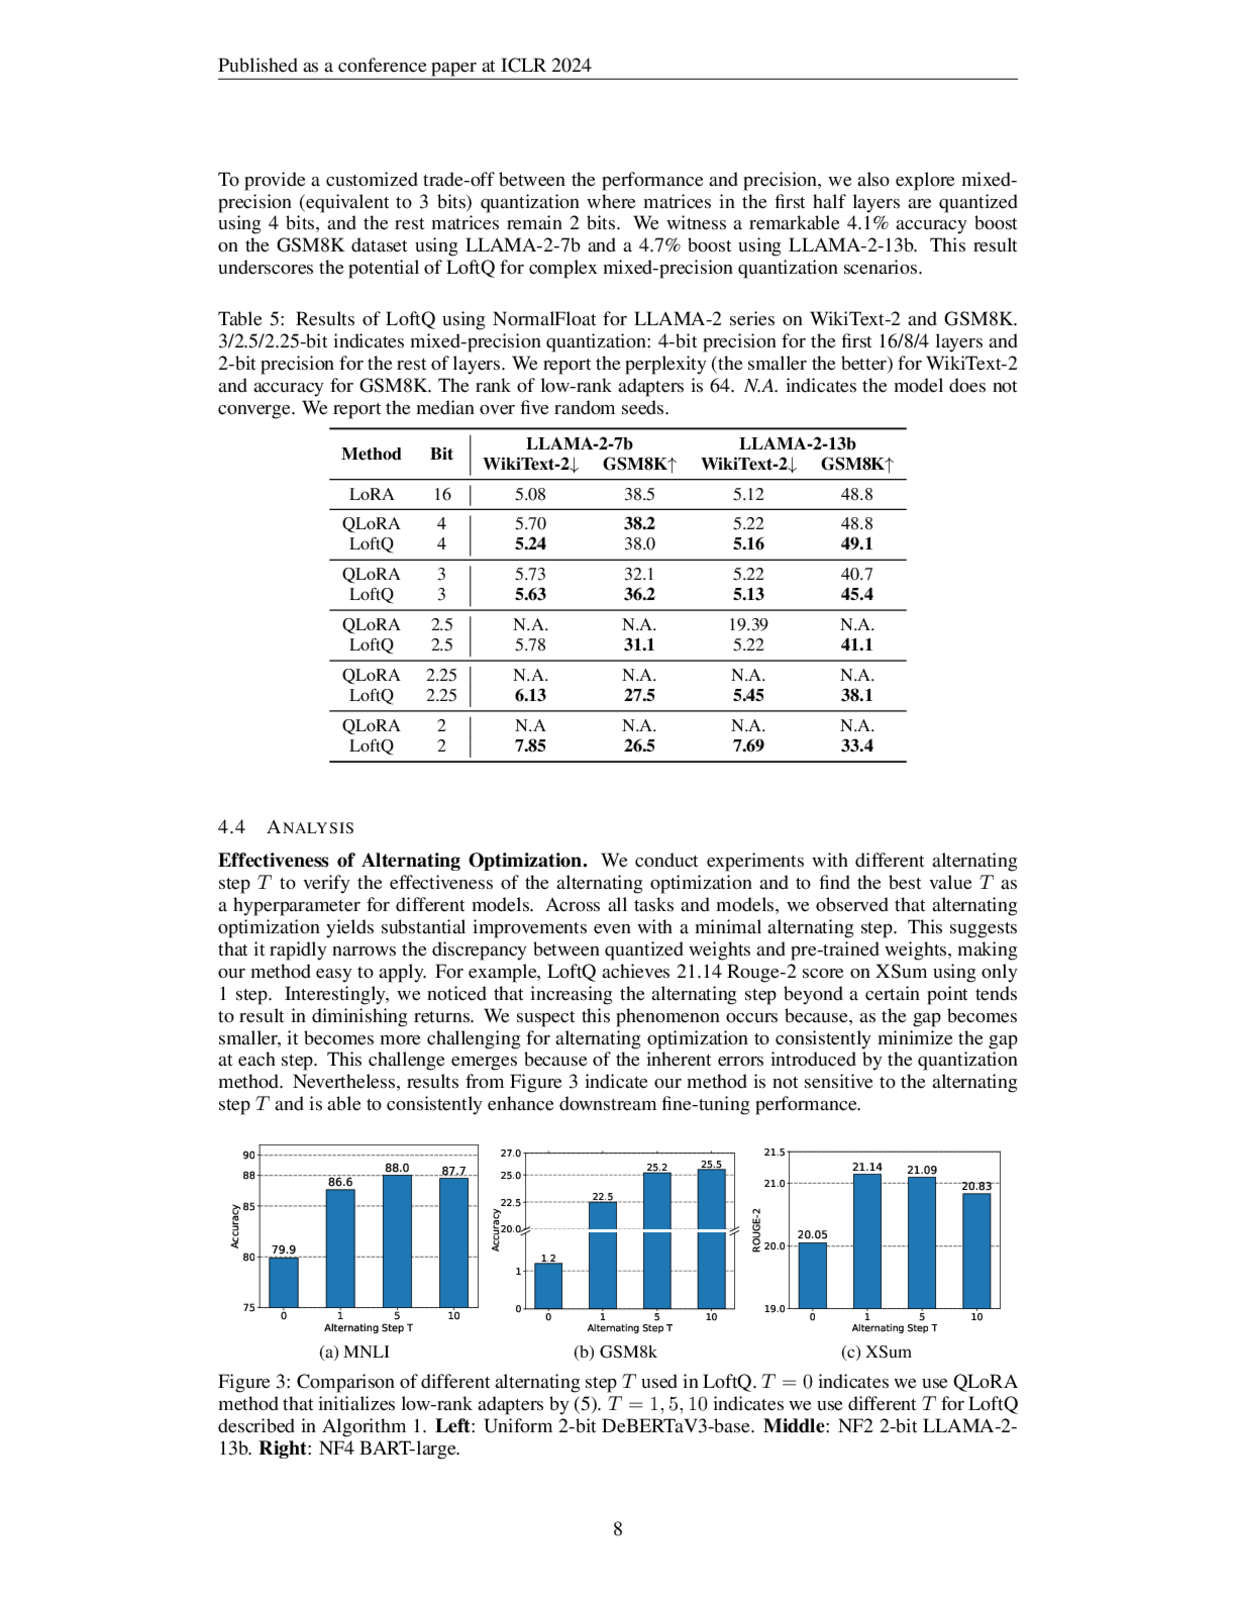

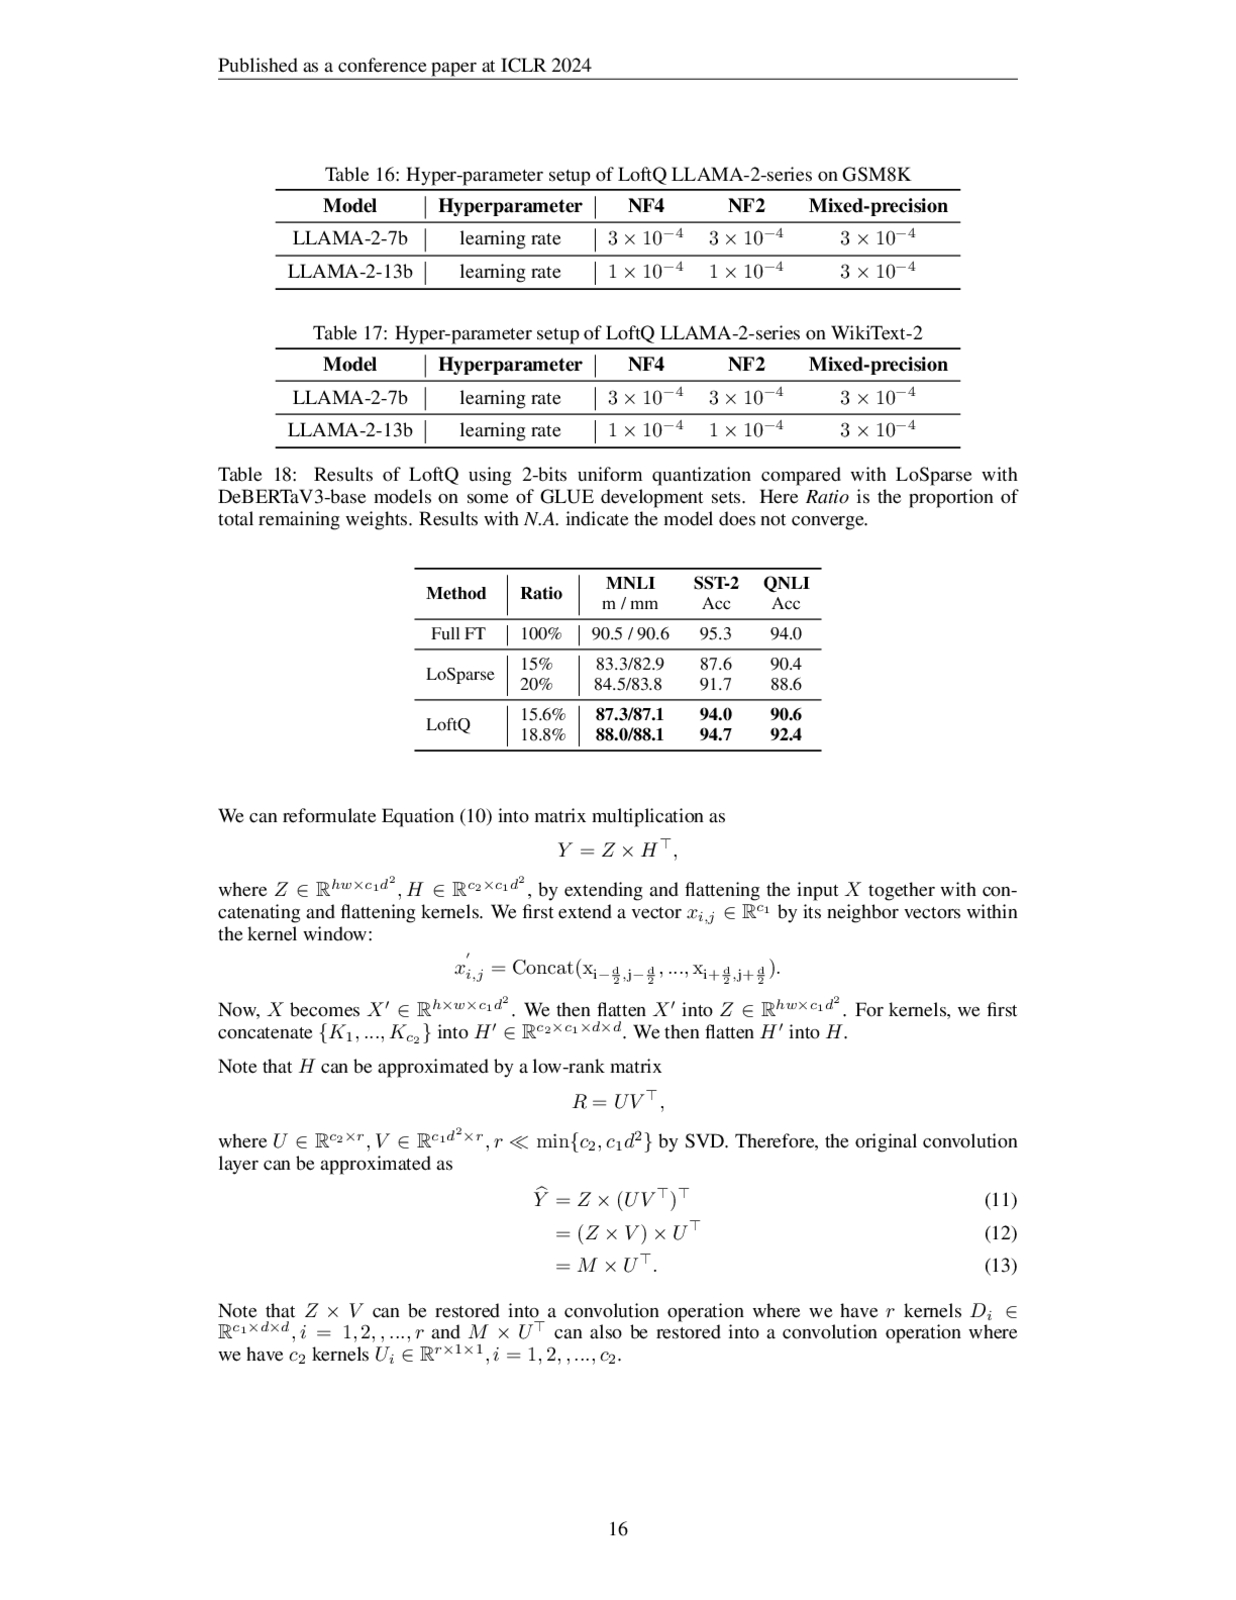

In [ ]:
ret["response"].response.render()

In [ ]:
ret = await agent.run(
    input="Help me generate a report comparing LongLoRA vs. LoftQ. "
    "What are similarities/differences in terms of techniques and experimental results?"
)

Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event DocRetrievalEvent
Running step handle_retrieval
Step handle_retrieval produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event DocRetrievalEvent
Running step handle_retrieval
Step handle_retrieval produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ReportGenerationEvent
Running step generate_report
Step generate_report produced event StopEvent


In [ ]:
ret["response"].response.render()

## Comparison of LongLoRA and LoftQ

### Similarities

1. **Purpose**: Both LongLoRA and LoftQ aim to improve the efficiency and performance of large language models (LLMs) during fine-tuning and inference.
2. **Efficiency**: Both methods focus on reducing computational costs and memory usage, making it feasible to work with large models on limited hardware resources.
3. **Fine-Tuning**: Both approaches involve fine-tuning pre-trained models to adapt them to specific tasks, although they use different techniques to achieve this.

### Differences

1. **Techniques**:
   - **LongLoRA**: Utilizes a combination of shifted sparse attention (S²-Attn) and low-rank adaptation (LoRA) to extend the context window of LLMs efficiently. It focuses on enabling long-context processing by approximating full attention with sparse attention during training.
   - **LoftQ**: Introduces a quantization framework that integrates low-rank approximation with quantization to provide a better initialization for LoRA fine-tuning. It aims to mitigate the discrepancy between quantized and full-precision models, especially in low-bit quantization scenarios.

2. **Experimental Results**:
   - **LongLoRA**: Demonstrates strong empirical results on various tasks with Llama2 models, extending context lengths significantly (e.g., Llama2 7B from 4k to 100k context). It shows improvements in training speed and memory efficiency while maintaining performance comparable to full fine-tuning.
   - **LoftQ**: Shows consistent improvements over QLoRA across different precision levels and tasks, including NLU, question answering, summarization, and NLG. It excels particularly in low-bit scenarios, achieving better performance and stability compared to QLoRA.

### Conclusion

Both LongLoRA and LoftQ offer innovative solutions to enhance the efficiency and performance of LLMs. LongLoRA focuses on extending context windows using sparse attention and low-rank adaptation, while LoftQ combines quantization with low-rank approximation to improve fine-tuning in low-bit precision regimes. Their techniques and experimental results highlight their respective strengths in handling large-scale models efficiently.

In [ ]:
from llama_index.utils.workflow import draw_most_recent_execution

draw_most_recent_execution(agent, notebook=False)

workflow_recent_execution.html
